In [27]:
from src.data import HARDataSet
from src.models import KAN, MLP
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [28]:
def train(model, train_loader, test_loader, total_test_samples):
    epochs = 50

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_losses, test_losses, accuracies = [], [], []

    for epoch in range(epochs):
        model.train()

        running_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)

                y_pred_test = model(X_batch)
                loss = criterion(y_pred_test, y_batch)
                test_loss += loss.item()

                pred = y_pred_test.argmax(dim=1, keepdim=True).squeeze()
                correct += pred.eq(y_batch).sum().item()

        test_losses.append(test_loss / len(test_loader))
        accuracies.append(correct / total_test_samples)

    return train_losses, test_losses, accuracies

In [29]:
X_train_file = "dataset/HAR/train/X_train.txt"
y_train_file = "dataset/HAR/train/y_train.txt"
X_test_file = "dataset/HAR/test/X_test.txt"
y_test_file = "dataset/HAR/test/y_test.txt"

train_dataset = HARDataSet(X_train_file, y_train_file)
test_dataset = HARDataSet(X_test_file, y_test_file)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [30]:
train_dataset.X.shape

torch.Size([7352, 561])

In [31]:
mlp = MLP(561, [512, 128], 6)
mlp_train_losses, mlp_test_losses, mlp_accuracies = train(
    mlp, train_loader, test_loader, total_test_samples=len(test_dataset)
)

In [32]:
kan = KAN([561, 128, 64, 6])
kan_train_losses, kan_test_losses, kan_accuracies = train(
    kan, train_loader, test_loader, total_test_samples=len(test_dataset)
)

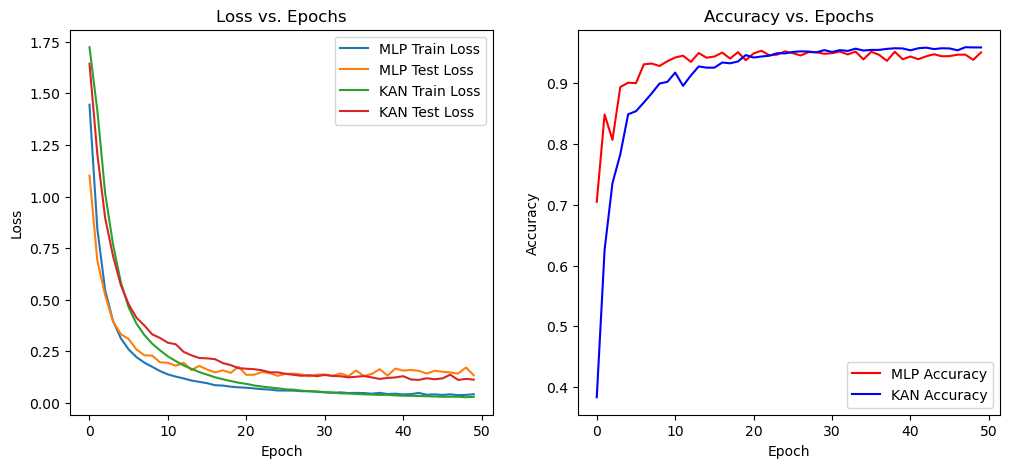

In [33]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_train_losses, label="MLP Train Loss")
plt.plot(mlp_test_losses, label="MLP Test Loss")
plt.plot(kan_train_losses, label="KAN Train Loss")
plt.plot(kan_test_losses, label="KAN Test Loss")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_accuracies, label="MLP Accuracy", color="r")
plt.plot(kan_accuracies, label="KAN Accuracy", color="b")
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [42]:
def add_label_noise(y_train: torch.Tensor, noise_level):
    num_swap_labels = int(
        np.round(len(y_train) * noise_level)
    )  # calculate the number of labels to swap
    np.random.seed(42)
    swap_indices = np.random.choice(
        len(y_train), num_swap_labels * 2, replace=False
    )  # randomly select indices to swap

    for i in range(0, len(swap_indices), 2):
        y_train[swap_indices[i]], y_train[swap_indices[i + 1]] = (
            y_train[swap_indices[i + 1]],
            y_train[swap_indices[i]],
        )

    return y_train

In [43]:
train_dataset.y = add_label_noise(train_dataset.y, 0.1)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [44]:
mlp = MLP(561, [512, 128], 6)
mlp_train_losses_10, mlp_test_losses_10, mlp_accuracies_10 = train(
    mlp, train_loader, test_loader, total_test_samples=len(test_dataset)
)

In [45]:
kan = KAN([561, 128, 64, 6])
kan_train_losses_10, kan_test_losses_10, kan_accuracies_10 = train(
    kan, train_loader, test_loader, total_test_samples=len(test_dataset)
)

In [46]:
train_dataset.y = add_label_noise(train_dataset.y, 0.15)

In [47]:
mlp = MLP(561, [512, 128], 6)
mlp_train_losses_15, mlp_test_losses_15, mlp_accuracies_15 = train(
    mlp, train_loader, test_loader, total_test_samples=len(test_dataset)
)

In [48]:
kan = KAN([561, 128, 64, 6])
kan_train_losses_15, kan_test_losses_15, kan_accuracies_15 = train(
    kan, train_loader, test_loader, total_test_samples=len(test_dataset)
)

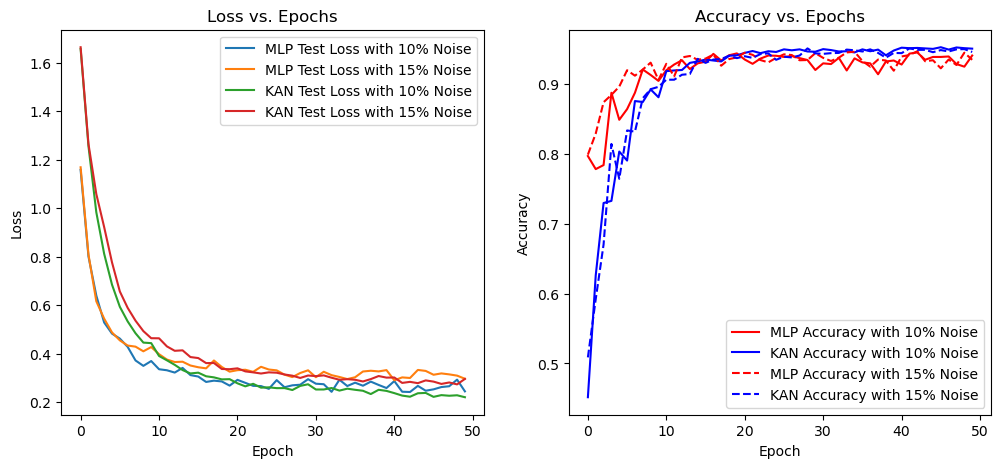

In [49]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mlp_test_losses_10, label="MLP Test Loss with 10% Noise")
plt.plot(mlp_test_losses_15, label="MLP Test Loss with 15% Noise")
plt.plot(kan_test_losses_10, label="KAN Test Loss with 10% Noise")
plt.plot(kan_test_losses_15, label="KAN Test Loss with 15% Noise")
plt.title("Loss vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(mlp_accuracies_10, label="MLP Accuracy with 10% Noise", color="r")
plt.plot(kan_accuracies_10, label="KAN Accuracy with 10% Noise", color="b")
plt.plot(
    mlp_accuracies_15, label="MLP Accuracy with 15% Noise", color="r", linestyle="--"
)
plt.plot(
    kan_accuracies_15, label="KAN Accuracy with 15% Noise", color="b", linestyle="--"
)
plt.title("Accuracy vs. Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()